In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd

DATASET_DIR = "/content/drive/MyDrive/Malaria_aug"  # change to your dataset path

data = []

for label in os.listdir(DATASET_DIR):
    class_dir = os.path.join(DATASET_DIR, label)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            data.append({
                "image_path": img_path,
                "label": label
            })

df = pd.DataFrame(data)
df.head()

,image_path,label
0,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
1,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
2,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
3,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
4,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax


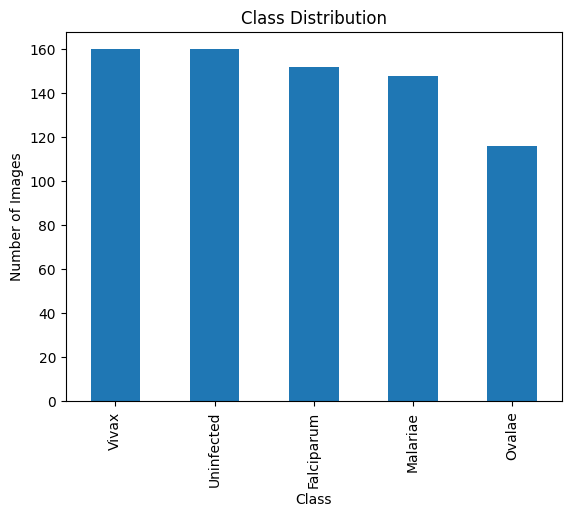

In [3]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [4]:
import cv2
import numpy as np

IMG_SIZE = 64  # small size to keep RF efficient

X = []
y = []

for _, row in df.iterrows():
    img = cv2.imread(row['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X.append(img.flatten())
    y.append(row['label'])

X = np.array(X)
y = np.array(y)

print("Feature shape:", X.shape)

Feature shape: (736, 4096)


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [17]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.527027027027027
              precision    recall  f1-score   support

  Falciparum       0.32      0.58      0.41        31
    Malariae       0.67      0.20      0.31        30
      Ovalae       1.00      0.09      0.16        23
  Uninfected       1.00      1.00      1.00        32
       Vivax       0.41      0.62      0.49        32

    accuracy                           0.53       148
   macro avg       0.68      0.50      0.48       148
weighted avg       0.66      0.53      0.50       148



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [14]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[16,  2,  3,  0, 10],
       [11, 11,  0,  0,  8],
       [ 5,  1,  5,  0, 12],
       [ 0,  0,  0, 32,  0],
       [10,  3,  2,  0, 17]])

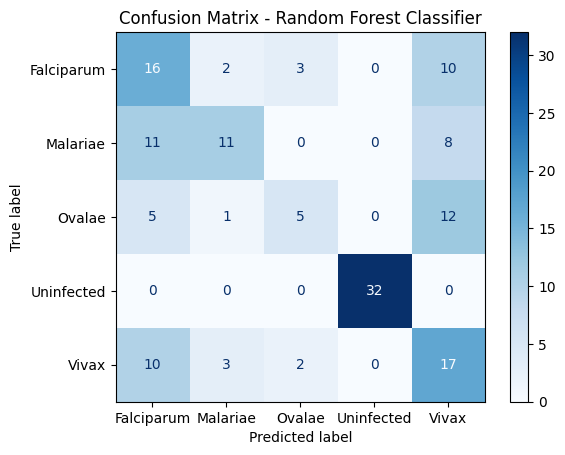

In [18]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()


In [19]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.feature import hog

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [22]:
DATASET_DIR = "/content/drive/MyDrive/Malaria_aug"  # 🔁 CHANGE THIS PATH

data = []

for label in os.listdir(DATASET_DIR):
    class_dir = os.path.join(DATASET_DIR, label)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            data.append({
                "image_path": os.path.join(class_dir, img_name),
                "label": label
            })

df = pd.DataFrame(data)
df.head()

,image_path,label
0,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
1,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
2,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
3,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
4,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax


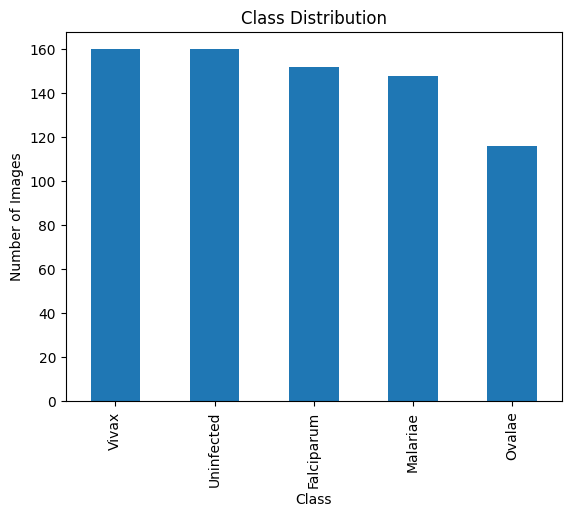

In [23]:
df['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [24]:
def extract_hog_features(df, img_size=64):
    X, y = [], []

    for img_path, label in tqdm(df[['image_path', 'label']].values):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))

        features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )

        X.append(features)
        y.append(label)

    return np.array(X), np.array(y)

In [25]:
X, y = extract_hog_features(df)
print("Feature shape:", X.shape)

100%|██████████| 736/736 [01:00<00:00, 12.17it/s]

Feature shape: (736, 1764)


In [26]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [31]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=4, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [28]:
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6824324324324325
              precision    recall  f1-score   support

  Falciparum       0.57      0.68      0.62        31
    Malariae       0.57      0.43      0.49        30
      Ovalae       0.80      0.52      0.63        23
  Uninfected       1.00      1.00      1.00        32
       Vivax       0.56      0.72      0.63        32

    accuracy                           0.68       148
   macro avg       0.70      0.67      0.67       148
weighted avg       0.70      0.68      0.68       148



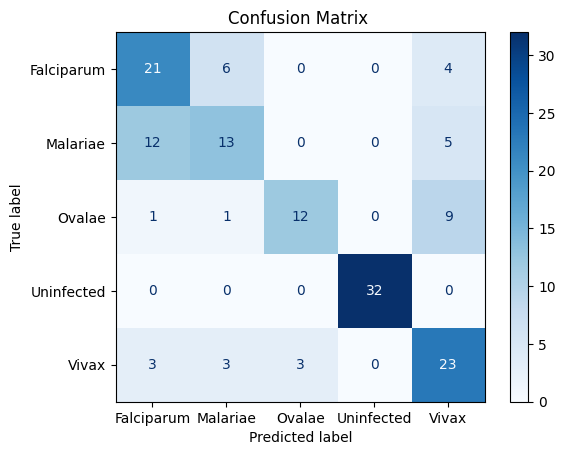

In [30]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix ")
plt.show()

In [32]:
import os

BASE_DIR = "/content/drive/MyDrive"
RF_VAL_DIR = os.path.join(BASE_DIR, "RF_Val")

os.makedirs(RF_VAL_DIR, exist_ok=True)

print("Folder created at:", RF_VAL_DIR)

Folder created at: /content/drive/MyDrive/RF_Val


In [33]:
import joblib

MODEL_PATH = os.path.join(RF_VAL_DIR, "random_forest_model.joblib")

joblib.dump(rf_model, MODEL_PATH)

print("Model saved at:", MODEL_PATH)

Model saved at: /content/drive/MyDrive/RF_Val/random_forest_model.joblib


In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d', ax=ax)
plt.title("Confusion Matrix - HOG + Random Forest")

CM_PLOT_PATH = os.path.join(RF_VAL_DIR, "confusion_matrix.png")
plt.savefig(CM_PLOT_PATH, dpi=300, bbox_inches="tight")
plt.close()

print("Confusion matrix saved at:", CM_PLOT_PATH)

Confusion matrix saved at: /content/drive/MyDrive/RF_Val/confusion_matrix.png
